<a href="https://colab.research.google.com/github/shengy90/MSc-Project/blob/master/notebooks/SOM_vs_PCA_12th_July.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Authenticate with BigQuery ☁️**

In [ ]:
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery --project machine-learning-msc df --use_bqstorage_api
SELECT 
  COUNT(*) as total_rows
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 

In [ ]:
df.head()

,total_rows
0,14841792


### **Importing Libraries⏬**

In [ ]:
!pip install MiniSom

  Created wheel for MiniSom: filename=MiniSom-2.2.6-cp36-none-any.whl size=8525 sha256=037d3d347a10b87b6fbbb2ffc68bc1629154101ba4c1e3d641fe0a4c35734016
  Stored in directory: /root/.cache/pip/wheels/b8/c6/01/330066e36e1f7c826c96f656f9185822cfcdef0591315949ea
Successfully built MiniSom


In [14]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import random

from tqdm import tqdm
from minisom import MiniSom
from datetime import date
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

sns.set()
%matplotlib inline

### **Downloading Datasets 🚚**
Note - this can take a while to download!


In [37]:
%%bigquery --project machine-learning-msc df --use_bqstorage_api
SELECT 
*,
ROW_NUMBER() OVER (PARTITION BY lcl_id, month_name ORDER BY dayofweek ASC, hhourly_rank ASC) AS weekly_rank
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 
WHERE month_name IN ('November', 'December', 'January') -- Only take Nov -> Jan data, to predict Feb, Mar, Apr
ORDER BY lcl_id, month_name ASC, dayofweek ASC, hhourly_rank ASC

In [38]:
df.head()

,lcl_id,acorn_grouped,acorn,month_name,dayofweek,hhourly_rank,hh_avg,hh_max,hh_min,hh_stddev,hh_median,hh_quartile_25,hh_quartile_75,weekly_rank
0,MAC000003,Adversity,P,December,1,0,1.3904,3.399,0.066,1.747546,0.148,0.132,3.207,1
1,MAC000003,Adversity,P,December,1,1,3.1894,3.337,3.062,0.102642,3.171,3.145,3.232,2
2,MAC000003,Adversity,P,December,1,2,2.9710,3.344,2.559,0.344394,3.089,2.659,3.204,3
3,MAC000003,Adversity,P,December,1,3,2.8374,3.234,2.170,0.415375,2.997,2.726,3.060,4
4,MAC000003,Adversity,P,December,1,4,2.4668,2.804,2.154,0.268141,2.360,2.333,2.683,5


### **Prepare Dataset**

###### Pivot table

In [39]:
def pivot_table(df):
    return pd.pivot_table(df, values=['hh_avg'], index=['lcl_id'], columns=['month_name','weekly_rank'], aggfunc=np.sum)
df_wide = pivot_table(df)
df_wide.columns = [''.join(str(col)) for col in df_wide.columns]

##### Splitting into test/ train set

In [40]:
def train_test_split(df, test_size=1000, random_state=0):
    test_df = df.sample(n=test_size, random_state=random_state)
    test_df_index = test_df.index.values.tolist()
    train_df = df_wide[~df_wide.index.isin(test_df_index)]
    assert len(train_df) + len(test_df) == len(df_wide)
    return train_df, test_df

In [41]:
train_df, test_df = train_test_split(df_wide)

In [43]:
train_df.shape, test_df.shape

((2681, 1008), (1000, 1008))

##### Normalise data

In [45]:
def normalise_df(train_df, test_df):

    train_mean = np.mean(train_df, axis=0)
    train_stdev = np.std(train_df, axis=0)

    # Normalise train and test set using only mean/ stdev of train set to avoid data leakage! 
    train_norm = (train_df - train_mean)/ train_stdev
    test_norm = (test_df - train_mean) / train_stdev 

    return train_norm.values, test_norm.values

In [46]:
train_norm, test_norm = normalise_df(train_df, test_df)

In [67]:
train_norm.shape, test_norm.shape

((2681, 1008), (1000, 1008))

### **Plotting functions**

##### **Plot distribution**

In [47]:
def prep_piechart_data(df):
    pie_chart_df = pd.DataFrame(df.groupby(['cluster_x', 'cluster_y', 'acorn_grouped'])['lcl_id'].nunique())
    pie_chart_df.reset_index(inplace=True)
    pie_chart_df = pd.pivot_table(pie_chart_df, values='lcl_id', index = ['cluster_x', 'cluster_y'], columns='acorn_grouped', aggfunc=np.sum)
    pie_chart_df.reset_index(inplace=True)
    pie_chart_df.fillna(0, inplace=True)
    return pie_chart_df 


def plot_pie_chart(input_df, gridsize=(3,3)):
    plt.figure(figsize=(10,10))
    grid = GridSpec(gridsize[0], gridsize[1])

    df = prep_piechart_data(input_df)

    for pos_i in tqdm(range(gridsize[0])):
        for pos_j in range(gridsize[1]):
            plt.subplot(grid[pos_i, pos_j])
            pie = df.query(f"cluster_x=={pos_i} and cluster_y=={pos_j}")[['ACORN-U', 'Adversity', 'Affluent', 'Comfortable']].values.tolist()[0]
            patches = plt.pie(pie)

    labels = ['ACORN-U', 'Adversity', 'Affluent', 'Comfortable']
    print(labels)
    plt.legend(labels, bbox_to_anchor=(0.5, 3.5), ncol=4)
    plt.show()

##### **Plot load profile**

In [102]:
def pick_random_lclids(df, num, position=None):
    """
    Function to pick random `num` lcl_ids from dataset
    Parameters:
        df : input dataframe 
        num: number of lcl_ids to output
    """
    if position is None:
        all_lcl_ids = list(set(df['lcl_id']))
    else:
        all_lcl_ids = list(set(df.query(f"cluster_x=={position[0]} and cluster_y=={position[1]}")['lcl_id']))
    
    try:
        id_list = np.random.choice(all_lcl_ids, num, replace=False) 
    except:
        id_list = np.random.choice(all_lcl_ids, num, replace=True) 
    return id_list

def get_load_profile(df, lcl_id, month):
    return df.query((f"lcl_id=='{lcl_id}' and month_name == '{month}'"))[['weekly_rank','hh_avg']]

def plot_clusters(cluster_df, month, gridsize=(3,3)):
    print(f"\nPlotting load profiles for {month}\n")

    plt.figure(figsize=(48, 16))
    the_grid = GridSpec(gridsize[0], gridsize[1])

    for pos_i in tqdm(range(gridsize[0])):
        for pos_j in range(gridsize[1]):
            plt.subplot(the_grid[pos_i, pos_j])

            ## Plot load profile of train set 
            train_df = cluster_df.query("train_test_split=='train'")
            lcl_ids = pick_random_lclids(train_df, 3, position=(pos_i,pos_j))
            for lcl_id in lcl_ids:
                load_profile = get_load_profile(cluster_df,lcl_id, month)
                plt.plot(load_profile['weekly_rank'], load_profile['hh_avg'], alpha=.5)
            ## Plot load profile of 1 test set
            test_df = cluster_df.query("train_test_split=='test'")
            test_id = pick_random_lclids(train_df, 1, position=(pos_i,pos_j))
            test_profile = get_load_profile(cluster_df,test_id[0], month)
            plt.plot(test_profile['weekly_rank'], test_profile['hh_avg'], color='black', linestyle=':', alpha=2)

## **SOM 3X3 clustering**

In [50]:
n_neurons = 3
m_neurons = 3
som = MiniSom(n_neurons, m_neurons, train_norm.shape[1], sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(train_norm)

In [51]:
som.train(train_norm, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 18.73293816539342


###**Prepare Data for plotting**

In [77]:
def get_som_clusters(norm_df, set_df, full_df):
    som_cluster_df = pd.DataFrame(set_df.groupby(['lcl_id']).count().reset_index()[['lcl_id']])
    som_cluster_df['cluster_x'] = np.NaN
    som_cluster_df['cluster_y'] = np.NaN

    for idx, xx in tqdm(enumerate(norm_df)):
        som_cluster_df.loc[idx, 'cluster_x'] = som.winner(xx)[0].astype(int)
        som_cluster_df.loc[idx, 'cluster_y'] = som.winner(xx)[1].astype(int)

    som_cluster_df = som_cluster_df.merge(full_df, on='lcl_id', how='inner')

    return som_cluster_df         

In [82]:
som_train = get_som_clusters(train_norm, train_df, df)
som_test = get_som_clusters(test_norm, test_df, df)
som_train['train_test_split'] = 'train'
som_test['train_test_split'] = 'test'

som_clusters = pd.concat([som_train, som_test])
som_clusters.shape, som_train.shape, som_test.shape, df.shape

2681it [00:02, 1079.42it/s]
1000it [00:00, 1124.84it/s]


((3710448, 17), (2702448, 17), (1008000, 17), (3710448, 14))

100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


['ACORN-U', 'Adversity', 'Affluent', 'Comfortable']


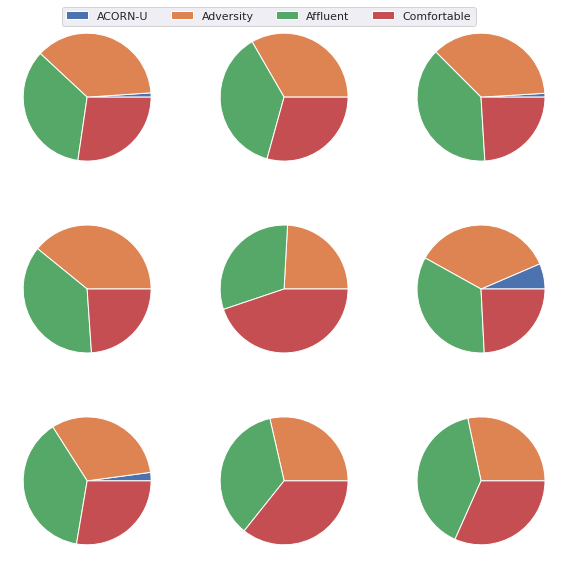

In [84]:
plot_pie_chart(som_test)

100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


['ACORN-U', 'Adversity', 'Affluent', 'Comfortable']


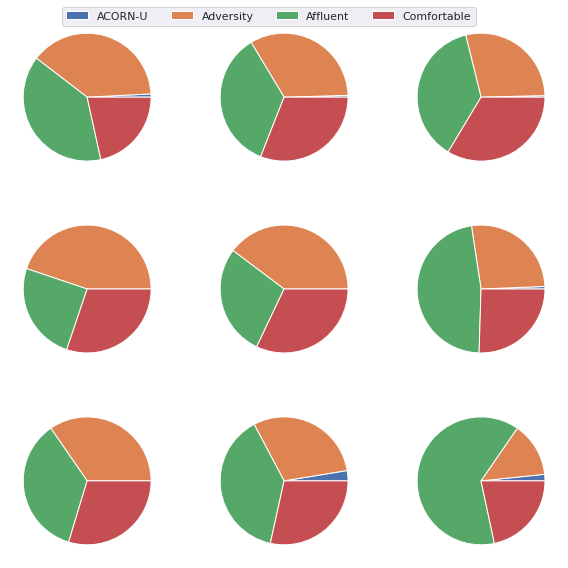

In [83]:
plot_pie_chart(som_train)

### **Plot Clusters**

  0%|          | 0/3 [00:00<?, ?it/s]


Plotting load profiles for January



100%|██████████| 3/3 [00:11<00:00,  3.73s/it]


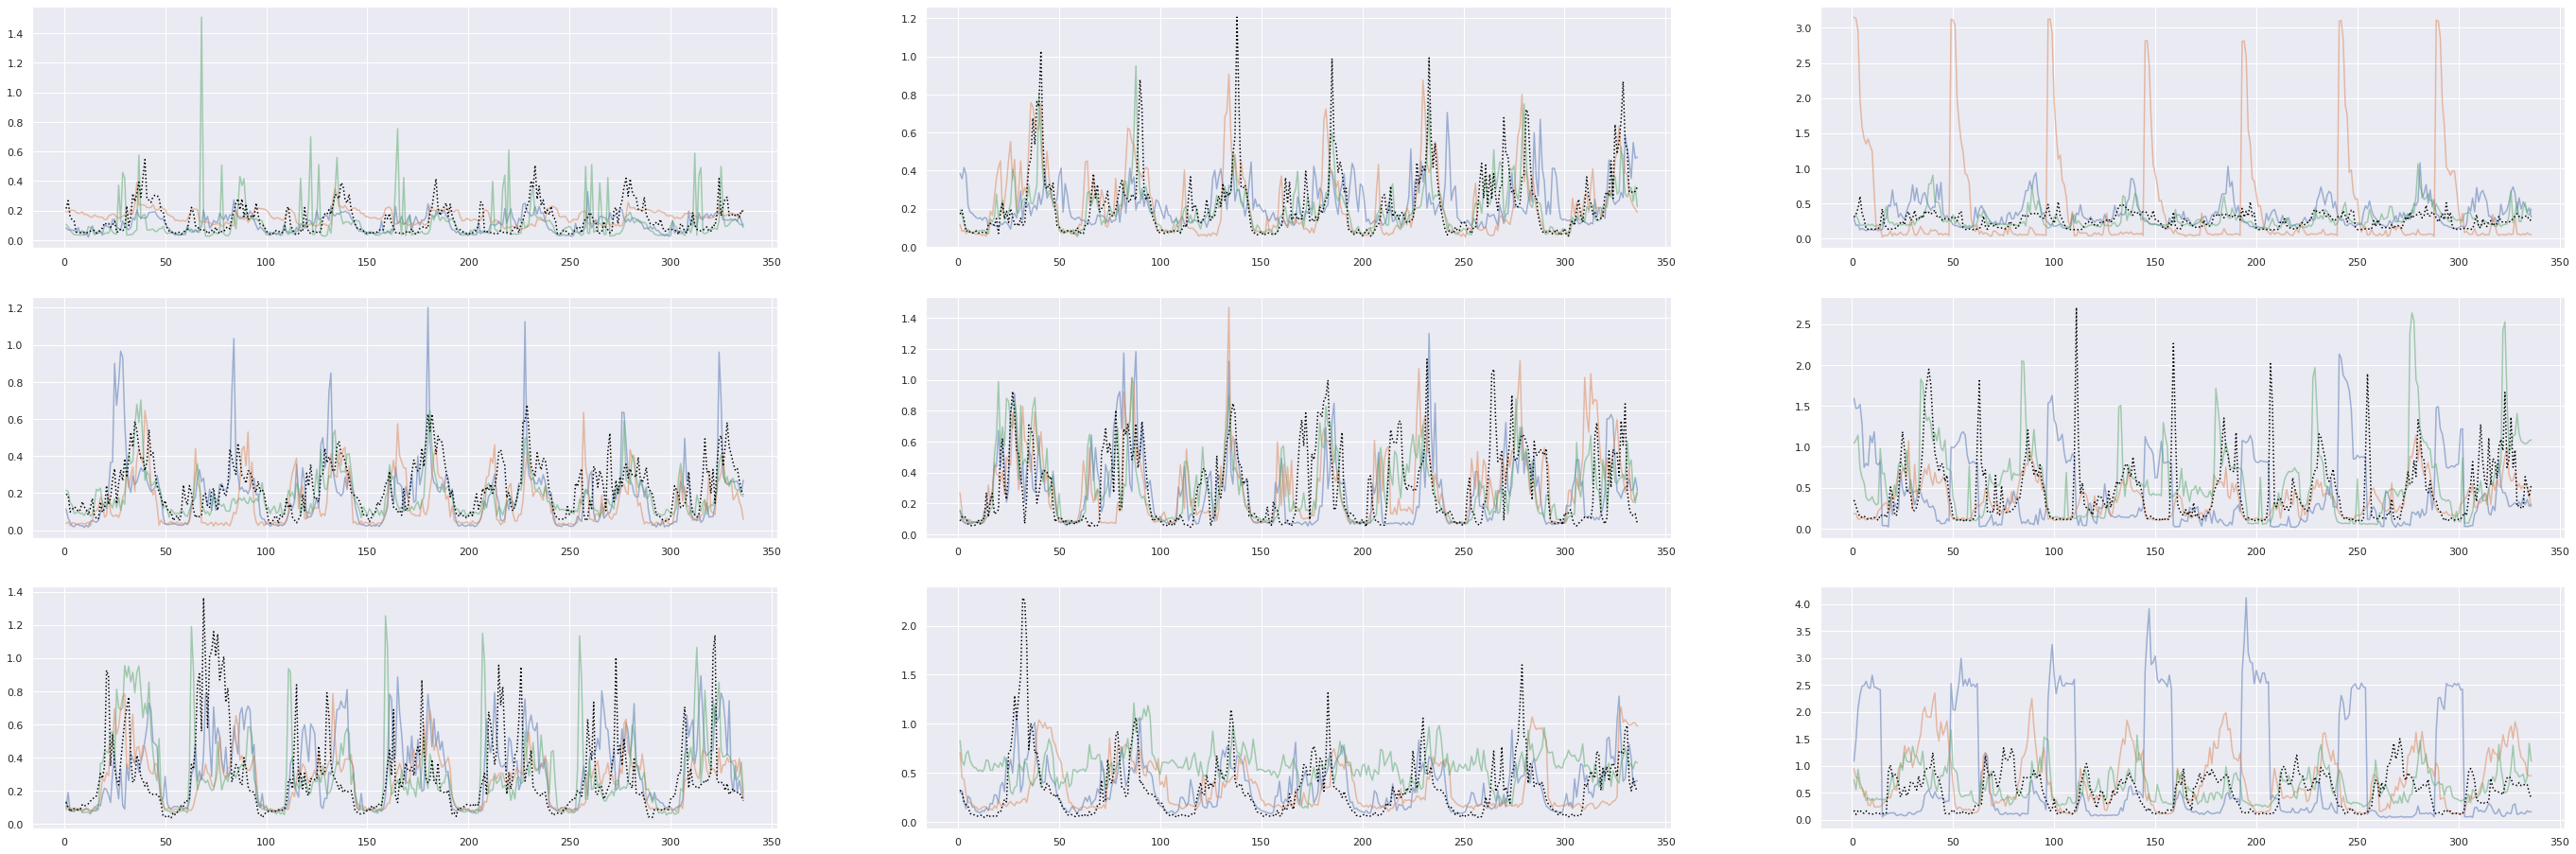

In [103]:
plot_clusters(som_clusters, 'January')

## **PCA + Agglomerative Hierarchical Clustering**

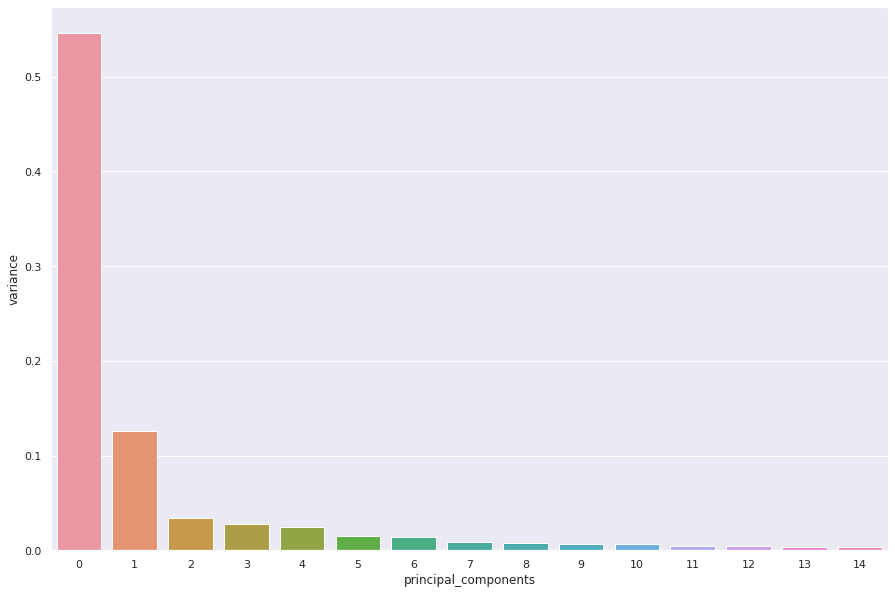

In [114]:
pca=None
pca = PCA(n_components=15)
pca.fit_transform(train_norm)
screeplot_df = pd.DataFrame(
    {'variance' : pca.explained_variance_ratio_,
     'principal_components': range(pca.n_components)}
     )
plt.figure(figsize=(15, 10))
sns.barplot(x='principal_components', y='variance', data=screeplot_df)

**Take first 8 principal components**

In [119]:
def pca_transform(norm_df, set_df, pca):
    principal_components = pca.transform(norm_df)
    pca_components = pd.DataFrame(
        index = set_df.index,
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15'],
        data = principal_components 
        )   
    return pca_components[['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8']].copy()

In [120]:
pca_train = pca_transform(train_norm, train_df, pca)
pca_test = pca_transform(test_norm, test_df, pca)

In [123]:
pca_train.shape, pca_test.shape

((2681, 8), (1000, 8))

In [126]:
agglo_cluster = AgglomerativeClustering(n_clusters=9)
agglo_cluster.fit(pca_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=9)

In [127]:
agglo_train_labels = pca_train.copy()
agglo_train_labels['cluster'] = pd.Categorical(agglo_cluster.labels_)
agglo_train_labels.reset_index(inplace=True)
agglo_train_labels.groupby('cluster').count()

,lcl_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
cluster,,,,,,,,,
0,1428,1428,1428,1428,1428,1428,1428,1428,1428
1,40,40,40,40,40,40,40,40,40
2,27,27,27,27,27,27,27,27,27
3,303,303,303,303,303,303,303,303,303
4,799,799,799,799,799,799,799,799,799
5,1,1,1,1,1,1,1,1,1
6,67,67,67,67,67,67,67,67,67
7,9,9,9,9,9,9,9,9,9
8,7,7,7,7,7,7,7,7,7


In [131]:
agglo_test_labels = pca_test.copy()
agglo_test_labels['cluster'] = pd.Categorical(agglo_cluster.fit_predict(pca_test))
agglo_test_labels.reset_index(inplace=True)
agglo_test_labels.groupby('cluster').count()

,lcl_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
cluster,,,,,,,,,
0,6,6,6,6,6,6,6,6,6
1,57,57,57,57,57,57,57,57,57
2,5,5,5,5,5,5,5,5,5
3,363,363,363,363,363,363,363,363,363
4,203,203,203,203,203,203,203,203,203
5,10,10,10,10,10,10,10,10,10
6,10,10,10,10,10,10,10,10,10
7,274,274,274,274,274,274,274,274,274
8,72,72,72,72,72,72,72,72,72


In [133]:
print(agglo_train_labels.shape, agglo_test_labels.shape)

(2681, 10) (1000, 10)


##### **Prepare data for plotting**

In [139]:
def cluster_x_coord(cluster):
     return np.floor(cluster/3).astype(int)

def cluster_y_coord(cluster):
    return np.mod(cluster,3).astype(int)

agglo_train_labels['cluster_x'] = agglo_train_labels['cluster'].apply(cluster_x_coord)
agglo_train_labels['cluster_y'] = agglo_train_labels['cluster'].apply(cluster_y_coord)
agglo_test_labels['cluster_x'] = agglo_test_labels['cluster'].apply(cluster_x_coord)
agglo_test_labels['cluster_y'] = agglo_test_labels['cluster'].apply(cluster_y_coord)
agglo_train_labels['train_test_split'] = 'train'
agglo_test_labels['train_test_split'] = 'test'

In [140]:
pca_clusters_train = agglo_train_labels.merge(df, on='lcl_id', how='inner')
pca_clusters_test = agglo_test_labels.merge(df, on='lcl_id', how='inner')
pca_clusters = pd.concat([pca_clusters_train, pca_clusters_test])

100%|██████████| 3/3 [00:00<00:00,  8.21it/s]


['ACORN-U', 'Adversity', 'Affluent', 'Comfortable']


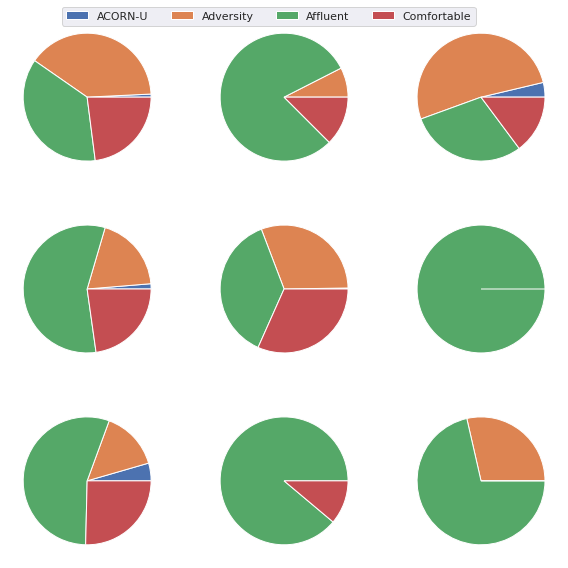

In [141]:
plot_pie_chart(pca_clusters_train)

100%|██████████| 3/3 [00:00<00:00, 16.05it/s]


['ACORN-U', 'Adversity', 'Affluent', 'Comfortable']


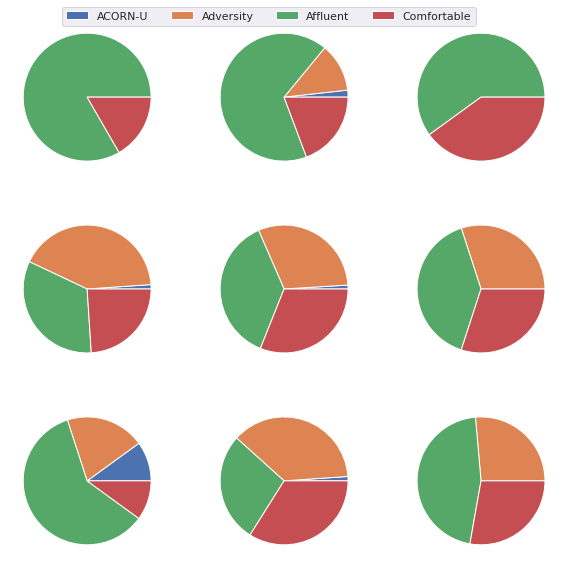

In [142]:
plot_pie_chart(pca_clusters_test)

##### **Plot clusters**

  0%|          | 0/3 [00:00<?, ?it/s]


Plotting load profiles for January



100%|██████████| 3/3 [00:13<00:00,  4.52s/it]


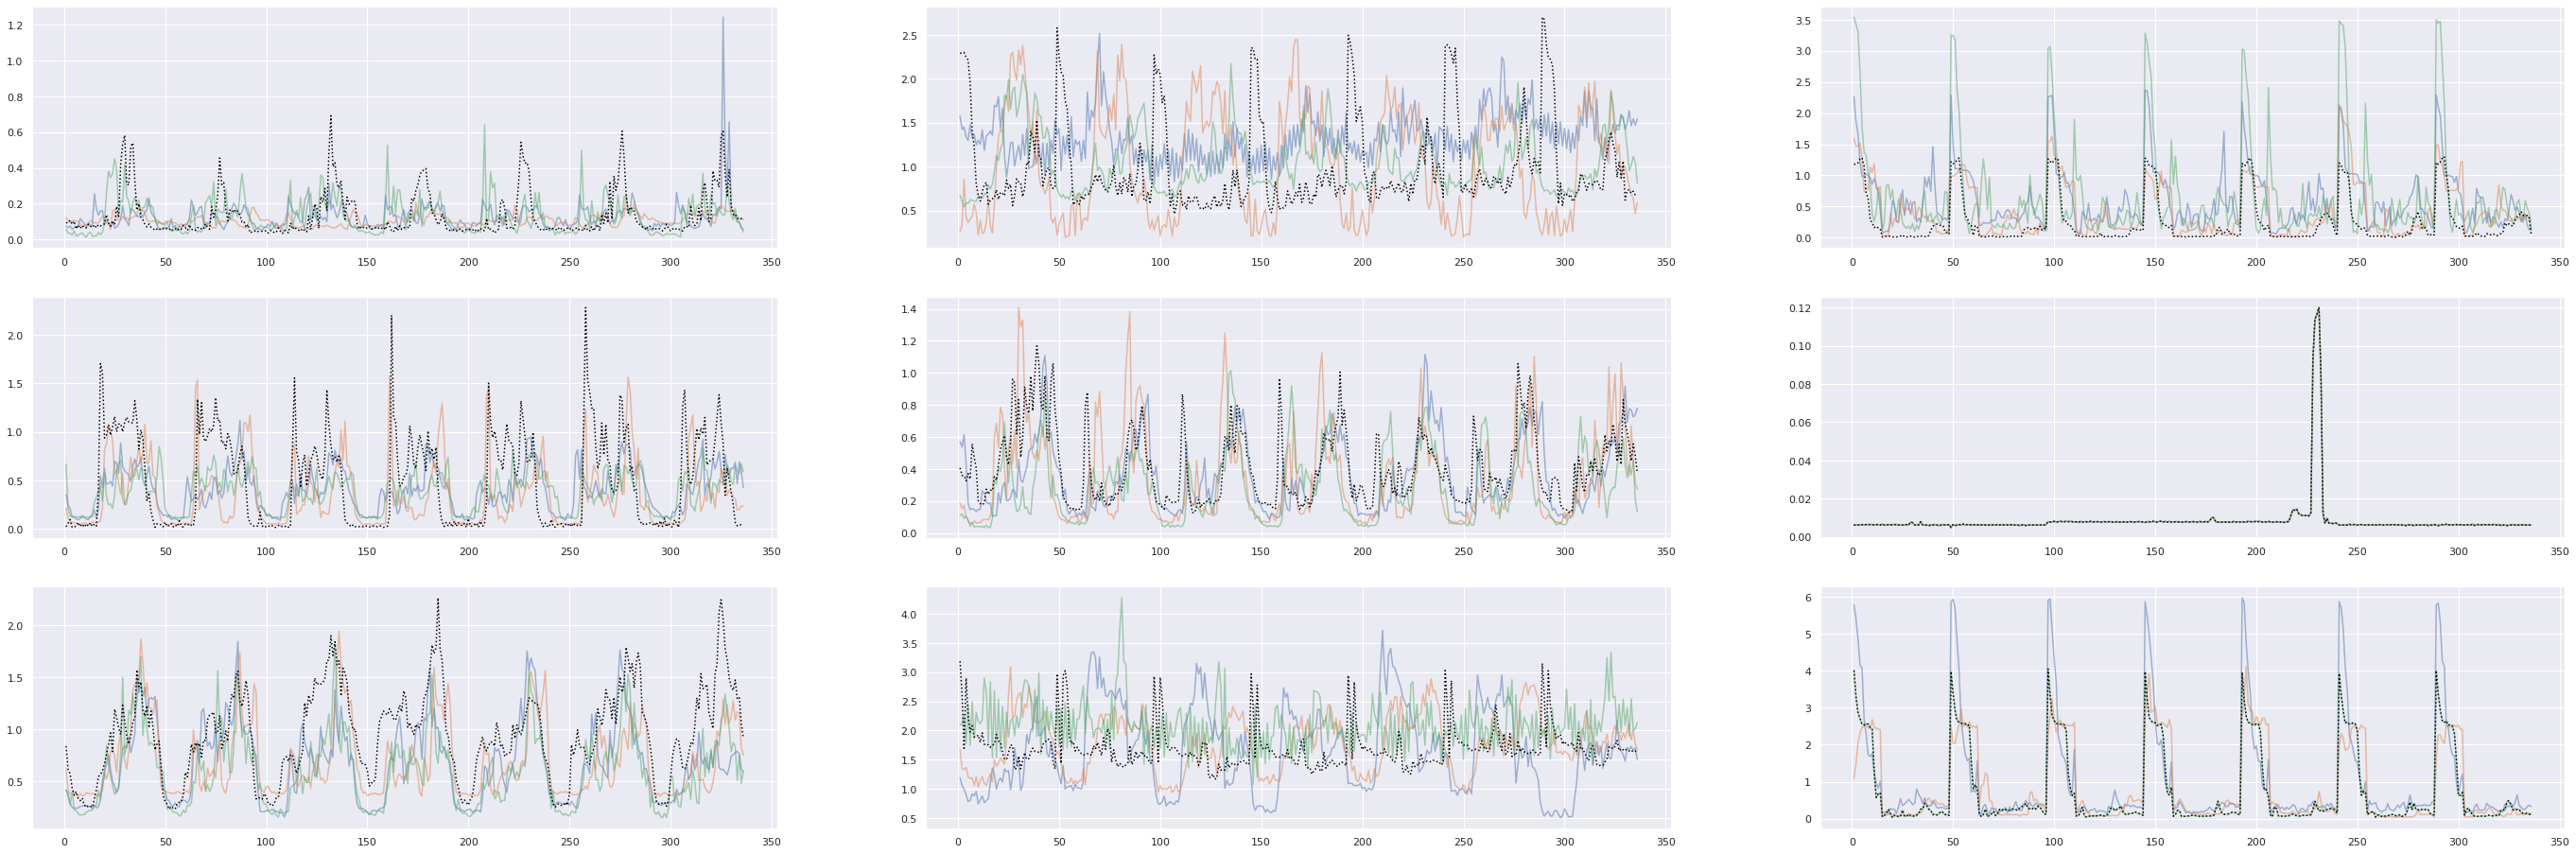

In [143]:
plot_clusters(pca_clusters, 'January')